In [805]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import erkal_rotation
import code_astro
from astropy import table
from astropy.coordinates import SkyCoord
from astropy import units as u
from start_plot import *
import pyfits

%matplotlib inline

In [806]:

streamname = 'Phoenix'
dm = 16.3
pt = 4

pmphi10 = -1.9
pmphi20 = -0.2
Z = 0.0001
age = 12.5



In [807]:
gband = 'WAVG_MAG_PSF_G_DERED'
rband = 'WAVG_MAG_PSF_R_DERED'
iband = 'WAVG_MAG_PSF_I_DERED'
zband = 'WAVG_MAG_PSF_Z_DERED'
Gband = 'PHOT_G_MEAN_MAG'
w1band = 'w1mpro'
w2band = 'w2mpro'
w3band = 'w3mpro'
w4band = 'w4mpro'

ra = 'RA'
dec = 'DEC'


def aatpointing(data, ra0, dec0):
    radius = np.sqrt(((data['ra'] - ra0) * np.cos(dec0 * np.pi/180))**2+(data['dec']-dec0)**2)
    return data[radius < 1.05]


In [808]:
streamgaia = pyfits.open('stream_data/'+streamname+'.fits')[1].data
fields = table.Table.read('stream_pointing_maps_v3.csv')
fields = fields[fields['#stream'] == streamname]
fields

#stream,ptnum,ra,dec,phi1,phi2
str11,int64,float64,float64,float64,float64
Phoenix,1,27.522008,-43.435281,-6.0,0.0
Phoenix,2,26.574582,-45.317191,-4.0,0.0
Phoenix,3,25.562194,-47.190731,-2.0,0.0
Phoenix,4,24.475886,-49.054701,0.0,0.0
Phoenix,5,23.305174,-50.907683,2.0,0.0
Phoenix,6,22.037714,-52.74799,4.0,0.0
Phoenix,7,20.658903,-54.573598,6.0,0.0


In [809]:
ra0 = fields['ra'][fields['ptnum']==pt][0]
dec0 = fields['dec'][fields['ptnum']==pt][0]
print ra0, dec0

#select with the FOV of AAO/2df
streamgaia = aatpointing(streamgaia, ra0, dec0)

#parallax cut
plx_cut = streamgaia['PARALLAX'] - 3 * streamgaia['PARALLAX_ERROR'] < 0.2
print '# of stars in the field:', len(streamgaia)
print '# of stars after parallax cut:', sum(plx_cut)

#substitute with MAG_AUTO if WAVG_MAG is not available
streamgaia[gband][streamgaia[gband] > 50] = streamgaia[streamgaia[gband] > 50]['MAG_AUTO_G_DERED']
streamgaia[rband][streamgaia[rband] > 50] = streamgaia[streamgaia[rband] > 50]['MAG_AUTO_R_DERED']
streamgaia[iband][streamgaia[iband] > 50] = streamgaia[streamgaia[iband] > 50]['MAG_AUTO_I_DERED']
streamgaia[zband][streamgaia[zband] > 50] = streamgaia[streamgaia[zband] > 50]['MAG_AUTO_Z_DERED']


24.475886 -49.054701
# of stars in the field: 9691
# of stars after parallax cut: 5950


In [810]:
#load isochrone, stellar locus, bhb ridgeline of m92

isofile = '/Users/tingli/.ugali/isochrones/dotter/iso_a%4.1f_z%7.5f.dat'%(age, Z)
dotter = np.loadtxt(isofile)
dotter_g = dotter[:,6]
dotter_r = dotter[:,7]
sl = pyfits.open('/Users/tingli/Dropbox/dwarfgalaxy/AAT/TucIII/y3a2_empirical_stellar_locus_griz.fits')[1].data

dm_m92_harris = 14.59
m92ebv = 0.023
m92ag = m92ebv * 3.184
m92ar = m92ebv * 2.130
m92_hb_r = np.array([16.8, 15.8, 15.38, 15.1])
m92_hb_col = np.array([-0.36, -0.3, -0.2, -0.0])
m92_hb_g = m92_hb_r + m92_hb_col
des_m92_hb_g = m92_hb_g - 0.104 * (m92_hb_g - m92_hb_r) + 0.01
des_m92_hb_r = m92_hb_r - 0.102 * (m92_hb_g - m92_hb_r) + 0.02
des_m92_hb_g = des_m92_hb_g - m92ag
des_m92_hb_r = des_m92_hb_r - m92ar


In [811]:
# making actual selections/cuts -- CMD cut and color-color cut

# CMD cut for RGB
grw = 0.07 # RGB width in gr
gw = 0.4 # RGB width in g
rmin = 15
rmax = 19.5
grmin = 0.
grmax = 1.1
magrange = (streamgaia[rband] > rmin) & (streamgaia[rband] < rmax) & (streamgaia[gband] - streamgaia[rband] < grmax) & (streamgaia[gband] - streamgaia[rband] > grmin)
gr = np.interp(streamgaia[gband], dotter_g[::-1] + dm, dotter_g[::-1] - dotter_r[::-1], left=np.nan, right=np.nan)
gg = np.interp(streamgaia[gband] - streamgaia[rband], dotter_g[dotter_g < 4] - dotter_r[dotter_g < 4],
               dotter_g[dotter_g < 4] + dm, left=np.nan, right=np.nan)
del_color_cmd = streamgaia[gband] - streamgaia[rband] - gr
del_g_cmd = streamgaia[gband] - gg

# CMD cut for BHB
grw_bhb = 0.10 # BHB width in gr
gw_bhb = 0.4  # BHB width in g
grmin_bhb = -0.5
grmax_bhb = 0
magrange_bhb = (streamgaia[rband] > rmin) & (streamgaia[rband] < rmax) & (streamgaia[gband] - streamgaia[rband] < grmax_bhb) & (streamgaia[gband] - streamgaia[rband] > grmin_bhb)
gr_bhb = np.interp(streamgaia[gband], des_m92_hb_g + dm - dm_m92_harris, des_m92_hb_g - des_m92_hb_r, left=np.nan,
                   right=np.nan)
gg_bhb = np.interp(streamgaia[gband] - streamgaia[rband], des_m92_hb_g - des_m92_hb_r, des_m92_hb_g + dm - dm_m92_harris,
                   left=np.nan, right=np.nan)
del_color_cmd_bhb = streamgaia[gband] - streamgaia[rband] - gr_bhb
del_g_cmd_bhb = streamgaia[gband] - gg_bhb

colorrange = magrange & ((abs(del_color_cmd) < grw) | (abs(del_g_cmd) < gw))
colorrange_bhb = magrange_bhb & ((abs(del_color_cmd_bhb) < grw_bhb) | (abs(del_g_cmd_bhb) < gw_bhb))
colorrange = colorrange | colorrange_bhb


# Color-color cut here to selection metal-poor stars
ri = np.interp(streamgaia[gband] - streamgaia[rband], sl['g'] - sl['r'], sl['r'] - sl['i'])
del_ri_locus = streamgaia[rband] - streamgaia[iband] - ri

# cuts used for color-color selection on RGB stars
rilow = 0.01 # metal-poor stars cut for RGB
rihigh = 0.10 # metal-poor stars cut for RGB
fehrange = (del_ri_locus > rilow) & (del_ri_locus < rihigh) & (streamgaia[gband] - streamgaia[rband] > 0.3) & (streamgaia[gband] - streamgaia[rband] < 1.0)
# color-color cut on BHB is just a big box
fehrange_bhb = (streamgaia[gband] - streamgaia[rband] < 0) & (streamgaia[gband] - streamgaia[rband] > -0.5) & (streamgaia[rband] - streamgaia[iband] < 0) & (streamgaia[rband] - streamgaia[iband] > -0.5)

# Add color-color cut
fehrange = fehrange | fehrange_bhb

# add PM cut
pmwidth_tight = 1
pmwidth_loose = 2
pmrange_tight = (abs(streamgaia['PMPHI1'] - pmphi10) < pmwidth_tight) & (abs(streamgaia['PMPHI2'] - pmphi20) < pmwidth_tight)
pmrange_loose = (abs(streamgaia['PMPHI1'] - pmphi10) < pmwidth_loose) & (abs(streamgaia['PMPHI2'] - pmphi20) < pmwidth_loose)
lowpmrange = (abs(streamgaia['PMPHI1']) < 5) & (abs(streamgaia['PMPHI2']) < 3)


stream_sel9 = plx_cut & colorrange & pmrange_tight & fehrange
stream_sel8 = plx_cut & colorrange & pmrange_loose
stream_sel7 = plx_cut & lowpmrange & colorrange & fehrange

print 'stream pri9:', sum(stream_sel9)
print 'stream pri8:', sum(stream_sel8)
print 'stream pri7:', sum(stream_sel7)


stream pri9: 9
stream pri8: 64
stream pri7: 48


/Users/tingli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in less
/Users/tingli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in less


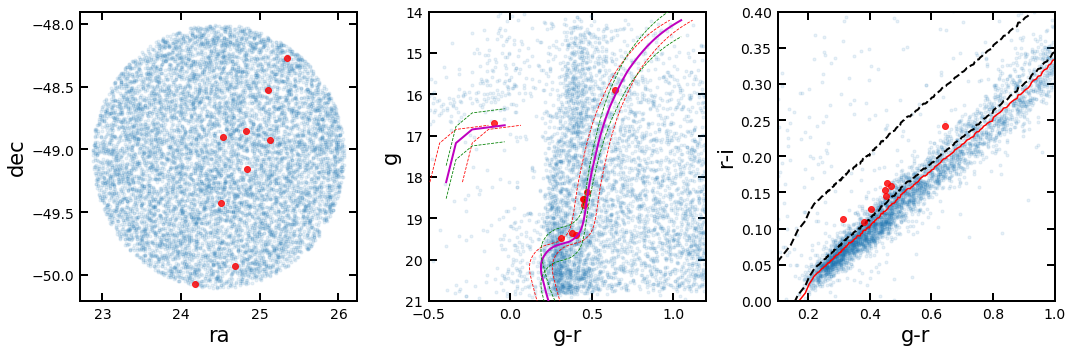

In [812]:
plt.figure(figsize = [15,5])

plt.subplot(131)
plt.plot(streamgaia[ra], streamgaia[dec], '.', alpha=0.1)
plt.plot(streamgaia[ra][stream_sel9], streamgaia[dec][stream_sel9], 'ro', alpha=0.8, zorder = 10)
#plt.plot(streamgaia[ra][stream_sel8], streamgaia[dec][stream_sel8], 'g^', alpha=0.8, zorder = 9)
#plt.plot(streamgaia[ra][stream_sel7], streamgaia[dec][stream_sel7], 'bx', alpha=0.8, zorder = 8)

plt.xlabel('ra')
plt.ylabel('dec')

plt.subplot(132)
plt.plot(streamgaia[gband]-streamgaia[rband], streamgaia[rband], '.', alpha=0.1)
plt.plot(streamgaia[gband][stream_sel9]-streamgaia[rband][stream_sel9], streamgaia[gband][stream_sel9], 'ro', alpha=0.8, zorder = 10)
#plt.plot(streamgaia[gband][stream_sel8]-streamgaia[rband][stream_sel8], streamgaia[gband][stream_sel8], 'g^', alpha=0.8, zorder = 9)
#plt.plot(streamgaia[gband][stream_sel7]-streamgaia[rband][stream_sel7], streamgaia[gband][stream_sel7], 'bx', alpha=0.8, zorder = 8)

plt.plot(dotter_g - dotter_r, dotter_g + dm, color='m', lw=2, zorder=16)
plt.plot(dotter_g - dotter_r - grw, dotter_g + dm, '--', color='r', lw=0.8, zorder=16)
plt.plot(dotter_g - dotter_r + grw, dotter_g + dm, '--', color='r', lw=0.8, zorder=16)
plt.plot(dotter_g - dotter_r, dotter_g + dm - gw, '--', color='g', lw=0.8, zorder=16)
plt.plot(dotter_g - dotter_r, dotter_g + dm + gw, '--', color='g', lw=0.8, zorder=16)

plt.plot(des_m92_hb_g - des_m92_hb_r, des_m92_hb_g + dm - dm_m92_harris, color='m', lw=2, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r - grw_bhb, des_m92_hb_g + dm - dm_m92_harris, '--', color='r', lw=0.8, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r + grw_bhb, des_m92_hb_g + dm - dm_m92_harris, '--', color='r', lw=0.8, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r, des_m92_hb_g + dm - dm_m92_harris - gw_bhb, '--', color='g', lw=0.8, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r, des_m92_hb_g + dm - dm_m92_harris + gw_bhb, '--', color='g', lw=0.8, zorder=16)

plt.ylim(21, 14)
plt.xlim(-0.5, 1.2)
plt.xlabel('g-r')
plt.ylabel('g')

plt.subplot(133)
plt.plot(streamgaia[gband]-streamgaia[rband], streamgaia[rband]-streamgaia[iband], '.', alpha=0.1)
plt.plot(streamgaia[gband][stream_sel9]-streamgaia[rband][stream_sel9], streamgaia[rband][stream_sel9]-streamgaia[iband][stream_sel9], 'ro', alpha=0.8, zorder = 10)
#plt.plot(streamgaia[gband][stream_sel8]-streamgaia[rband][stream_sel8], streamgaia[rband][stream_sel8]-streamgaia[iband][stream_sel8], 'g^', alpha=0.8, zorder = 9)
#plt.plot(streamgaia[gband][stream_sel7]-streamgaia[rband][stream_sel7], streamgaia[rband][stream_sel7]-streamgaia[iband][stream_sel7], 'bx', alpha=0.8, zorder = 8)

plt.plot(sl['g'] - sl['r'], sl['r'] - sl['i'], 'r-')
plt.plot(sl['g']-sl['r'],sl['r']-sl['i']+rilow, 'k--',lw=2)
plt.plot(sl['g']-sl['r'],sl['r']-sl['i']+rihigh, 'k--',lw=2)
plt.ylim(0., 0.4)
plt.xlim(0.1, 1.0)
plt.xlabel('g-r')
plt.ylabel('r-i')

plt.tight_layout()

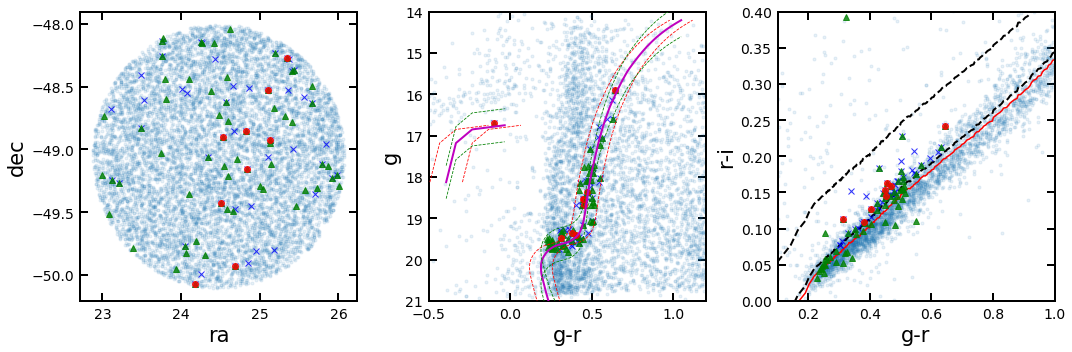

In [813]:
plt.figure(figsize = [15,5])

plt.subplot(131)
plt.plot(streamgaia[ra], streamgaia[dec], '.', alpha=0.1)
plt.plot(streamgaia[ra][stream_sel9], streamgaia[dec][stream_sel9], 'ro', alpha=0.8, zorder = 10)
plt.plot(streamgaia[ra][stream_sel8], streamgaia[dec][stream_sel8], 'g^', alpha=0.8, zorder = 9)
plt.plot(streamgaia[ra][stream_sel7], streamgaia[dec][stream_sel7], 'bx', alpha=0.8, zorder = 8)

plt.xlabel('ra')
plt.ylabel('dec')

plt.subplot(132)
plt.plot(streamgaia[gband]-streamgaia[rband], streamgaia[rband], '.', alpha=0.1)
plt.plot(streamgaia[gband][stream_sel9]-streamgaia[rband][stream_sel9], streamgaia[gband][stream_sel9], 'ro', alpha=0.8, zorder = 10)
plt.plot(streamgaia[gband][stream_sel8]-streamgaia[rband][stream_sel8], streamgaia[gband][stream_sel8], 'g^', alpha=0.8, zorder = 9)
plt.plot(streamgaia[gband][stream_sel7]-streamgaia[rband][stream_sel7], streamgaia[gband][stream_sel7], 'bx', alpha=0.8, zorder = 8)

plt.plot(dotter_g - dotter_r, dotter_g + dm, color='m', lw=2, zorder=16)
plt.plot(dotter_g - dotter_r - grw, dotter_g + dm, '--', color='r', lw=0.8, zorder=16)
plt.plot(dotter_g - dotter_r + grw, dotter_g + dm, '--', color='r', lw=0.8, zorder=16)
plt.plot(dotter_g - dotter_r, dotter_g + dm - gw, '--', color='g', lw=0.8, zorder=16)
plt.plot(dotter_g - dotter_r, dotter_g + dm + gw, '--', color='g', lw=0.8, zorder=16)

plt.plot(des_m92_hb_g - des_m92_hb_r, des_m92_hb_g + dm - dm_m92_harris, color='m', lw=2, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r - grw_bhb, des_m92_hb_g + dm - dm_m92_harris, '--', color='r', lw=0.8, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r + grw_bhb, des_m92_hb_g + dm - dm_m92_harris, '--', color='r', lw=0.8, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r, des_m92_hb_g + dm - dm_m92_harris - gw_bhb, '--', color='g', lw=0.8, zorder=16)
plt.plot(des_m92_hb_g - des_m92_hb_r, des_m92_hb_g + dm - dm_m92_harris + gw_bhb, '--', color='g', lw=0.8, zorder=16)

plt.ylim(21, 14)
plt.xlim(-0.5, 1.2)
plt.xlabel('g-r')
plt.ylabel('g')

plt.subplot(133)
plt.plot(streamgaia[gband]-streamgaia[rband], streamgaia[rband]-streamgaia[iband], '.', alpha=0.1)
plt.plot(streamgaia[gband][stream_sel9]-streamgaia[rband][stream_sel9], streamgaia[rband][stream_sel9]-streamgaia[iband][stream_sel9], 'ro', alpha=0.8, zorder = 10)
plt.plot(streamgaia[gband][stream_sel8]-streamgaia[rband][stream_sel8], streamgaia[rband][stream_sel8]-streamgaia[iband][stream_sel8], 'g^', alpha=0.8, zorder = 9)
plt.plot(streamgaia[gband][stream_sel7]-streamgaia[rband][stream_sel7], streamgaia[rband][stream_sel7]-streamgaia[iband][stream_sel7], 'bx', alpha=0.8, zorder = 8)

plt.plot(sl['g'] - sl['r'], sl['r'] - sl['i'], 'r-')
plt.plot(sl['g']-sl['r'],sl['r']-sl['i']+rilow, 'k--',lw=2)
plt.plot(sl['g']-sl['r'],sl['r']-sl['i']+rihigh, 'k--',lw=2)

plt.ylim(0., 0.4)
plt.xlim(0.1, 1.0)
plt.xlabel('g-r')
plt.ylabel('r-i')

plt.tight_layout()

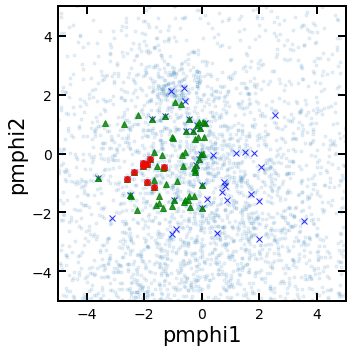

In [814]:
plt.figure(figsize = [5,5])

plt.subplot(111)
plt.plot(streamgaia['pmphi1'], streamgaia['pmphi2'], '.', alpha=0.1)
plt.plot(streamgaia['pmphi1'][stream_sel9], streamgaia['pmphi2'][stream_sel9], 'ro', alpha=0.8, zorder = 10)
plt.plot(streamgaia['pmphi1'][stream_sel8], streamgaia['pmphi2'][stream_sel8], 'g^', alpha=0.8, zorder = 9)
plt.plot(streamgaia['pmphi1'][stream_sel7], streamgaia['pmphi2'][stream_sel7], 'bx', alpha=0.8, zorder = 8)

plt.xlabel('pmphi1')
plt.ylabel('pmphi2')
plt.xlim(-5,5)
plt.ylim(-5,5)

plt.tight_layout()

In [815]:
bhb_pri6 = plx_cut & (streamgaia[gband]-streamgaia[rband] < 0) & ((streamgaia[gband]-streamgaia[rband] > -0.4)) & (streamgaia[rband] < 19) & (streamgaia[rband]>15)
print 'number of BHBs:', sum(bhb_pri6)

number of BHBs: 11


In [816]:
rrl_gaia = pyfits.open('../RRL/RRL_GDR2.fits')[1].data

rrl_gaia = aatpointing(rrl_gaia, ra0, dec0)
rrl_gaia = rrl_gaia[(rrl_gaia['phot_g_mean_mag'] > 15) & (rrl_gaia['phot_g_mean_mag'] < 19)]

c = SkyCoord(ra=rrl_gaia['ra']*u.degree, dec=rrl_gaia['dec']*u.degree)
catalog = SkyCoord(ra=streamgaia['ra']*u.degree, dec=streamgaia['dec']*u.degree)
match, d2d, d3d = c.match_to_catalog_sky(catalog)
rrl_des = streamgaia[match][d2d < 1*u.arcsec]

print 'number of RRL:', len(rrl_gaia)
print 'number of RRL in DES photometry:', len(rrl_des)

number of RRL: 3
number of RRL in DES photometry: 3


In [817]:
wd_gaia = table.Table.read('WD-DIR/gaia_dr2_wd_candidates_DES-cut2.csv')
wd_gaia['ra'] = wd_gaia['ra_gaia']
wd_gaia['dec'] = wd_gaia['dec_gaia']

wd_gaia = aatpointing(wd_gaia, ra0, dec0)
wd_gaia = wd_gaia[(wd_gaia['phot_g_mean_mag'] > 15) & (wd_gaia['phot_g_mean_mag'] < 19)]

c = SkyCoord(ra=wd_gaia['ra_gaia']*u.degree, dec=wd_gaia['dec_gaia']*u.degree)
catalog = SkyCoord(ra=streamgaia['ra']*u.degree, dec=streamgaia['dec']*u.degree)
match, d2d, d3d = c.match_to_catalog_sky(catalog)
wd_des = streamgaia[match][d2d < 1*u.arcsec]
print 'number of WD:', len(wd_gaia)
print 'number of WD in DES photometry:', len(wd_des)

number of WD: 3
number of WD in DES photometry: 3


In [818]:
emp_gaia = table.Table.read('SkyMapper_EMP_candidates.dat', format='ascii')
emp_gaia = aatpointing(emp_gaia, ra0, dec0)
emp_gaia = emp_gaia[(emp_gaia['Gmag'] > 15) & (emp_gaia['Gmag'] < 19)]

c = SkyCoord(ra=emp_gaia['ra']*u.degree, dec=emp_gaia['dec']*u.degree)
catalog = SkyCoord(ra=streamgaia['ra']*u.degree, dec=streamgaia['dec']*u.degree)
match, d2d, d3d = c.match_to_catalog_sky(catalog)
emp_des = streamgaia[match][d2d < 1*u.arcsec]

print 'number of EMP:', len(emp_gaia)
print 'number of EMP in DES photometry:', len(emp_des)

number of EMP: 8
number of EMP in DES photometry: 8


number of Metal-Poor stars: 70


Text(0,0.5,'r-i')

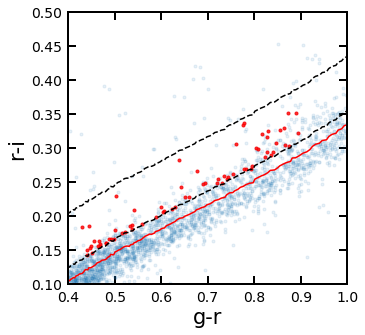

In [891]:
# Color-color cut here to selection metal-poor stars
ri = np.interp(streamgaia[gband] - streamgaia[rband], sl['g'] - sl['r'], sl['r'] - sl['i'])
del_ri_locus = streamgaia[rband] - streamgaia[iband] - ri

# cuts used for color-color selection on RGB stars
rilow = 0.02 # metal-poor stars cut for RGB. v1 = 0.02, v2 = 0.01
rihigh = 0.10 # metal-poor stars cut for RGB
mp_pri4 = (del_ri_locus > rilow) & (del_ri_locus < rihigh) 
mp_pri4 &= (streamgaia[gband]-streamgaia[rband] > 0.4) & (streamgaia[gband]-streamgaia[rband] < 0.9)
mp_pri4 &= (streamgaia[rband] < 18.5) & (streamgaia[rband] > 15)
mp_pri4 &= plx_cut
print 'number of Metal-Poor stars:', sum(mp_pri4)


plt.figure(figsize=[5,5])
plt.plot(streamgaia[gband]-streamgaia[rband], streamgaia[rband]-streamgaia[iband], '.', alpha=0.1)
plt.plot(streamgaia[gband][bhb_pri6]-streamgaia[rband][bhb_pri6], streamgaia[rband][bhb_pri6]-streamgaia[iband][bhb_pri6], '.', alpha=0.8)
plt.plot(streamgaia[gband][mp_pri4]-streamgaia[rband][mp_pri4], streamgaia[rband][mp_pri4]-streamgaia[iband][mp_pri4], 'r.', alpha=0.8)

plt.plot(sl['g'] - sl['r'], sl['r'] - sl['i'], 'r-')
plt.plot(sl['g'] - sl['r'], sl['r'] - sl['i']+rilow, 'k--')
plt.plot(sl['g'] - sl['r'], sl['r'] - sl['i']+rihigh, 'k--')

plt.ylim(0.1, 0.5)
plt.xlim(0.4, 1.0)
plt.xlabel('g-r')
plt.ylabel('r-i')

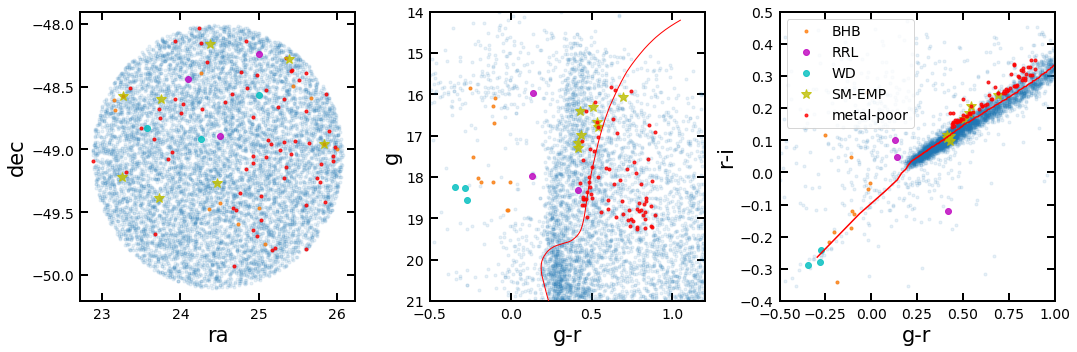

In [820]:
plt.figure(figsize = [15,5])

plt.subplot(131)
plt.plot(streamgaia[ra], streamgaia[dec], '.', alpha=0.1)
plt.plot(streamgaia[ra][bhb_pri6], streamgaia[dec][bhb_pri6], '.', alpha=0.8)
plt.plot(streamgaia[ra][mp_pri4], streamgaia[dec][mp_pri4], 'r.', alpha=0.8)
plt.plot(rrl_des[ra], rrl_des[dec], 'mo', alpha=0.8)
plt.plot(wd_des[ra], wd_des[dec], 'co', alpha=0.8)
plt.plot(emp_des[ra], emp_des[dec], 'y*', alpha=0.8, ms=10)

plt.xlabel('ra')
plt.ylabel('dec')

plt.subplot(132)
plt.plot(streamgaia[gband]-streamgaia[rband], streamgaia[gband], '.', alpha=0.1)
plt.plot(streamgaia[gband][bhb_pri6]-streamgaia[rband][bhb_pri6], streamgaia[gband][bhb_pri6], '.', alpha=0.8)
plt.plot(rrl_des[gband]-rrl_des[rband], rrl_des[gband], 'mo', alpha=0.8)
plt.plot(wd_des[gband]-wd_des[rband], wd_des[gband], 'co', alpha=0.8)
plt.plot(emp_des[gband]-emp_des[rband], emp_des[gband], 'y*', alpha=0.8, ms=10)
plt.plot(streamgaia[gband][mp_pri4]-streamgaia[rband][mp_pri4], streamgaia[gband][mp_pri4], 'r.', alpha=0.8)

plt.plot(dotter_g-dotter_r, dotter_g+dm, color='r', lw=1, zorder=6)
plt.ylim(21, 14)
plt.xlim(-0.5, 1.2)
plt.xlabel('g-r')
plt.ylabel('g')

plt.subplot(133)
plt.plot(streamgaia[gband]-streamgaia[rband], streamgaia[rband]-streamgaia[iband], '.', alpha=0.1)
plt.plot(streamgaia[gband][bhb_pri6]-streamgaia[rband][bhb_pri6], streamgaia[rband][bhb_pri6]-streamgaia[iband][bhb_pri6], '.', alpha=0.8, label='BHB')
plt.plot(rrl_des[gband]-rrl_des[rband], rrl_des[rband]-rrl_des[iband], 'mo', alpha=0.8, label='RRL')
plt.plot(wd_des[gband]-wd_des[rband], wd_des[rband]-wd_des[iband], 'co', alpha=0.8, label='WD')
plt.plot(emp_des[gband]-emp_des[rband], emp_des[rband]-emp_des[iband], 'y*', alpha=0.8, ms=10, label='SM-EMP')
plt.plot(streamgaia[gband][mp_pri4]-streamgaia[rband][mp_pri4], streamgaia[rband][mp_pri4]-streamgaia[iband][mp_pri4], 'r.', alpha=0.8, label='metal-poor')
plt.legend(loc=2)

plt.plot(sl['g'] - sl['r'], sl['r'] - sl['i'], 'r-')
plt.ylim(-0.4, 0.5)
plt.xlim(-0.5, 1.0)
plt.xlabel('g-r')
plt.ylabel('r-i')

plt.tight_layout()

In [734]:
wisecat = table.Table(wisecat)

In [821]:
c = SkyCoord(ra=streamgaia['ra']*u.degree, dec=streamgaia['dec']*u.degree)
catalog = SkyCoord(ra=wisecat['ra']*u.degree, dec=wisecat['dec']*u.degree)
match, d2d, d3d = c.match_to_catalog_sky(catalog)

mask = d2d < 1*u.arcsec

wise_data = table.Table(wisecat[match][mask])
des_data = table.Table(streamgaia[mask])

wise_des_match = table.hstack((des_data, wise_data))


In [822]:
giant_gaia = streamgaia[plx_cut]
c = SkyCoord(ra=giant_gaia['ra']*u.degree, dec=giant_gaia['dec']*u.degree)
catalog = SkyCoord(ra=wisecat['ra']*u.degree, dec=wisecat['dec']*u.degree)
match, d2d, d3d = c.match_to_catalog_sky(catalog)

mask = d2d < 1*u.arcsec

wise_data = table.Table(wisecat[match][mask])
des_data = table.Table(giant_gaia[mask])

wise_des_match = table.hstack((des_data, wise_data))


In [962]:
def sel_giant(data,gmag,rmag,zmag,w1mag, w2mag):
    sel = (data[gmag] - data[rmag] < 1.1)
    sel &= (data[zmag] - data[w1mag] > 1.8)
    sel &= (data[zmag] - data[w1mag] < 1.0 * (data[gmag] - data[rmag]) + 1.20)
    sel &= (data[zmag] - data[w1mag] > 1.0 * (data[gmag] - data[rmag]) + 0.95)
    sel &= (data[w1mag] - data[w2mag] < 0)
    sel &= (data[w1mag] - data[w2mag] > -0.4)
    sel &= (data[w1mag] < 15.5)
    sel &= (data[rband] > 15)
    return data[sel]

giant_data = sel_giant(wise_des_match, gband, rband, zband, w1band, w2band)

print "# of giant stars:", len(giant_data)

# of giant stars: 9


In [1003]:
low_pm_sel = plx_cut & (streamgaia[gband]-streamgaia[rband] > 0.4) & (streamgaia[gband]-streamgaia[rband] < 1.0)
low_pm_sel &= (abs(streamgaia['PMPHI1']) < 3) & (abs(streamgaia['PMPHI2']) < 3)
low_pm_sel &= (streamgaia[rband] < 18.5) & (streamgaia[rband] > 15)

print "# of low PM stars:", sum(low_pm_sel)

# of low PM stars: 132


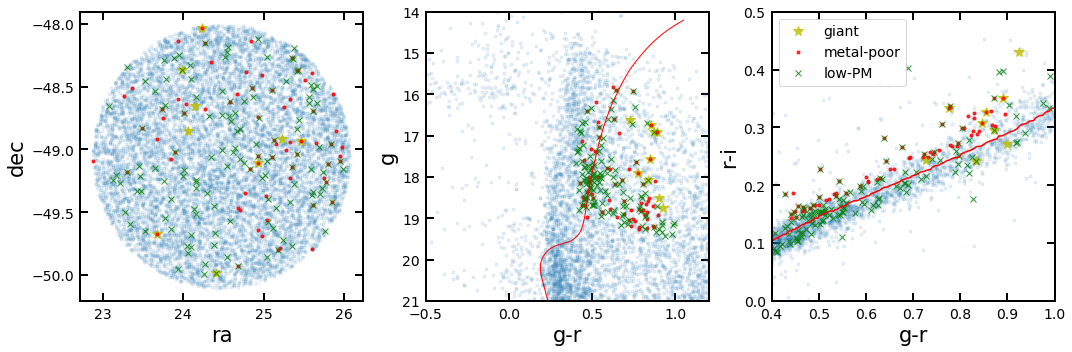

In [1004]:
plt.figure(figsize = [15,5])

plt.subplot(131)
plt.plot(streamgaia[ra], streamgaia[dec], '.', alpha=0.1)
plt.plot(giant_data[ra], giant_data[dec], 'y*', alpha=0.8, ms=10)
plt.plot(streamgaia[ra][mp_pri4], streamgaia[dec][mp_pri4], 'r.', alpha=0.8)
plt.plot(streamgaia[ra][low_pm_sel], streamgaia[dec][low_pm_sel], 'gx', alpha=0.8)

plt.xlabel('ra')
plt.ylabel('dec')

plt.subplot(132)
plt.plot(streamgaia[gband]-streamgaia[rband], streamgaia[gband], '.', alpha=0.1)
plt.plot(giant_data[gband]-giant_data[rband],giant_data[gband], 'y*', alpha=0.8, ms=10)
plt.plot(streamgaia[gband][mp_pri4]-streamgaia[rband][mp_pri4], streamgaia[gband][mp_pri4], 'r.', alpha=0.8)
plt.plot(streamgaia[gband][low_pm_sel]-streamgaia[rband][low_pm_sel], streamgaia[gband][low_pm_sel], 'gx', alpha=0.8)

plt.plot(dotter_g-dotter_r, dotter_g+dm, color='r', lw=1, zorder=6)
plt.ylim(21, 14)
plt.xlim(-0.5, 1.2)
plt.xlabel('g-r')
plt.ylabel('g')

plt.subplot(133)
plt.plot(streamgaia[gband]-streamgaia[rband], streamgaia[rband]-streamgaia[iband], '.', alpha=0.1)
plt.plot(giant_data[gband]-giant_data[rband],giant_data[rband]-giant_data[iband], 'y*', alpha=0.8, ms=10, label='giant')
plt.plot(streamgaia[gband][mp_pri4]-streamgaia[rband][mp_pri4], streamgaia[rband][mp_pri4]-streamgaia[iband][mp_pri4], 'r.', alpha=0.8, label='metal-poor')
plt.plot(streamgaia[gband][low_pm_sel]-streamgaia[rband][low_pm_sel], streamgaia[rband][low_pm_sel]-streamgaia[iband][low_pm_sel], 'gx', alpha=0.8, label='low-PM')
plt.legend(loc=2)

plt.plot(sl['g'] - sl['r'], sl['r'] - sl['i'], 'r-')
plt.ylim(0.0, 0.5)
plt.xlim(0.4, 1.0)
plt.xlabel('g-r')
plt.ylabel('r-i')

plt.tight_layout()

In [1005]:
galaxy = table.Table.read('galaxy_survey/field_'+streamname+'_'+str(pt)+'_targets.csv')

galaxy_high = galaxy[galaxy['priority'] == 8]
galaxy_low = galaxy[galaxy['priority'] == 9]
print "# of high pri galaxy:", len(galaxy_high)
print "# of low pri galaxy:", len(galaxy_low)
galaxy_high

# of high pri galaxy: 52
# of low pri galaxy: 186


OBJID,RA,DEC,r_mag,priority
int64,float64,float64,float64,int64
232001361,24.1130241300133,-49.8427006680419,19.744234085083008,8
230880955,22.9868366363648,-48.9889352076587,19.006345748901367,8
230884056,23.2128077257816,-49.0380165974557,18.979551315307617,8
240171867,25.4784813564776,-48.4069846782941,19.398269653320312,8
241574603,25.1192920741777,-49.8811142075975,18.245241165161133,8
250814942,25.8550622084553,-49.4497643369594,18.91376495361328,8
250813875,25.7742247196548,-49.4294615777931,19.86358070373535,8
241574068,24.8244581995526,-49.8674259298528,19.713214874267578,8
250802349,25.7194401220303,-49.2092425958967,19.203651428222656,8


In [1006]:
target_list = table.Table()

In [1007]:
pri9 = table.Table()
pri9 = table.Table(streamgaia[stream_sel9])['SOURCE_ID', 'RA', 'DEC', Gband]
pri9['PRI'] = np.zeros(len(pri9))+9
pri9

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
4929905436787781120,25.09873082062469,-48.52231869702214,18.190716000000002,9.0
4929893552615350400,24.53301682430325,-48.89810785414856,19.141365,9.0
4929932924578515456,25.352598376180897,-48.2684724872369,17.996107000000002,9.0
4917499647092253824,24.684147837554498,-49.92619196115545,18.343687,9.0
4917764187014054272,24.506684199361214,-49.429593594989846,16.754139000000002,9.0
4917664779994240256,24.17288271467915,-50.07002136040272,19.101107,9.0
4917862490225433984,24.83681415055152,-49.153255166635844,15.371351999999998,9.0
4917874374398472064,25.124462280280838,-48.924162130214945,18.200197,9.0
4917885236370646272,24.826134459502352,-48.85407029519791,19.536875,9.0


In [1008]:
pri8 = table.Table()
pri8 = table.Table(streamgaia[stream_sel8])['SOURCE_ID', 'RA', 'DEC', Gband]
pri8['PRI'] = np.zeros(len(pri8))+8
pri8

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
4930073700723633792,23.763266143909078,-48.25342040699128,18.840363,8.0
4929984464186394112,24.423335905591244,-48.15229097304135,17.579788,8.0
4929875097139320064,24.10012767354116,-48.4398964044336,17.980165,8.0
4929905436787781120,25.09873082062469,-48.52231869702214,18.190716000000002,8.0
4929883313412993408,23.789787627965964,-48.435675593641975,17.917417999999998,8.0
4929839882703648000,23.491629676625546,-48.831005621380406,16.074783,8.0
4929986697569397632,24.250784014944674,-48.140016688708805,19.13544,8.0
4929786414654702976,23.74641834964747,-49.02758001375455,19.452842999999998,8.0
4929893552615350400,24.53301682430325,-48.89810785414856,19.141365,8.0


In [1009]:
pri7 = table.Table()
pri7 = table.Table(streamgaia[stream_sel7])['SOURCE_ID', 'RA', 'DEC', Gband]
pri7['PRI'] = np.zeros(len(pri7))+7
pri7

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
4930073700723633792,23.763266143909078,-48.25342040699128,18.840363,7.0
4929905436787781120,25.09873082062469,-48.52231869702214,18.190716000000002,7.0
4930073838162567936,23.491095188692665,-48.40786713210011,19.046846,7.0
4929872146498026880,24.06988685566784,-48.54638778891733,18.611729999999998,7.0
4929915057514701056,24.659141291091327,-48.49666900395653,19.197682999999998,7.0
4929839882703648000,23.491629676625546,-48.831005621380406,16.074783,7.0
4929986697569397632,24.250784014944674,-48.140016688708805,19.13544,7.0
4930038443335254400,23.113906385545448,-48.675092725171076,19.079805,7.0
4929893552615350400,24.53301682430325,-48.89810785414856,19.141365,7.0


In [1010]:
pri61 = table.Table()
pri61 = table.Table(streamgaia[bhb_pri6])['SOURCE_ID', 'RA', 'DEC', Gband]
pri61['PRI'] = np.zeros(len(pri61))+6
pri61

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
4929968521267646848,24.26532434298866,-48.39316052685052,18.0622,6.0
4930038207113827968,23.163502603264078,-48.68748763884633,18.130669,6.0
4930041604431754368,23.146805250828137,-48.6080097110241,18.46787,6.0
4917601145759285376,25.08611253874413,-49.75628213914675,16.358543,6.0
4917764187014054272,24.506684199361214,-49.429593594989846,16.754139000000002,6.0
4917835032497762176,26.006170822444393,-48.9948831883465,12.935516999999999,6.0
4917906401971178240,25.67672402952091,-48.58888092734403,18.641920000000002,6.0
4917713094083105536,24.733102456735576,-49.59373488037804,16.140785,6.0
4917758994397453312,24.36250727214665,-49.471801641317555,17.682014000000002,6.0


In [1011]:
pri62 = table.Table()
pri62 = table.Table(rrl_gaia)['source_id_gdr2', 'ra', 'dec', 'phot_g_mean_mag']
pri62.rename_column('source_id_gdr2', 'SOURCE_ID')
pri62.rename_column('ra', 'RA')
pri62.rename_column('dec', 'DEC')
pri62.rename_column('phot_g_mean_mag', Gband)
pri62['PRI'] = np.zeros(len(pri62))+6
pri62['SOURCE_ID'].dtype = '>i8'
pri62

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
4886716398090320789,25.0083759478,-48.2383285055,15.8493843079,6.0
4886716253873377430,24.507420671,-48.8952180604,17.9545001984,6.0
4886716327219168445,24.1001276735,-48.4398964044,17.9801654816,6.0


In [1012]:
pri63 = table.Table()
pri63 = table.Table(wd_gaia)['source_id', 'ra_gaia', 'dec_gaia', 'phot_g_mean_mag']
pri63.rename_column('source_id', 'SOURCE_ID')
pri63.rename_column('ra_gaia', 'RA')
pri63.rename_column('dec_gaia', 'DEC')
pri63.rename_column('phot_g_mean_mag', Gband)
pri63['PRI'] = np.zeros(len(pri63))+6
pri63

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
4929839019414238976,23.571178028405328,-48.82684685627932,18.424670000000003,6.0
4929802013975642752,24.257932177136873,-48.920197935046566,18.463135,6.0
4929904955751439104,25.00567039913522,-48.56436963529801,18.749874,6.0


In [1013]:
pri5 = table.Table()
pri5 = table.Table(emp_gaia)['source_id', 'ra', 'dec', 'Gmag']
pri5.rename_column('source_id', 'SOURCE_ID')
pri5.rename_column('ra', 'RA')
pri5.rename_column('dec', 'DEC')
pri5.rename_column('Gmag', Gband)
pri5['PRI'] = np.zeros(len(pri5))+5
pri5

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
4929823802346047616,23.245998872161188,-49.223401474739546,15.491128,5.0
4930045044701778304,23.263369632306798,-48.57685724251002,16.224077,5.0
4929763226127326208,23.72598233036811,-49.38542912094678,16.677906,5.0
4929876888141903488,23.74507973103176,-48.60111701973133,16.062998,5.0
4929984880799956736,24.38242301112992,-48.158486540164404,15.904093,5.0
4917770028169592320,24.46683458770578,-49.269217957746456,16.867628,5.0
4929938559575606144,25.396045946163532,-48.27655684538365,16.987494,5.0
4917838816365793792,25.839105432765276,-48.95933039632863,16.34243,5.0


In [1014]:
pri4 = table.Table()
pri4 = table.Table(streamgaia[mp_pri4])['SOURCE_ID', 'RA', 'DEC', Gband]
pri4['PRI'] = np.zeros(len(pri4))+4
pri4

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
4929975702453116160,24.84279584896593,-48.13809588415272,18.318375,4.0
4929834964965060864,23.66670846218388,-48.919800519769026,17.373404999999998,4.0
4929821122285188992,24.27182822927882,-48.67395261891123,18.408903,4.0
4929905436787781120,25.09873082062469,-48.52231869702214,18.190716000000002,4.0
4929806416318502656,23.89570628163652,-49.01763844647584,19.025122,4.0
4929861288820687872,24.005038814845907,-48.711094233069446,15.293035999999999,4.0
4929863311749298176,23.744520917386193,-48.74632542172913,18.643492000000002,4.0
4929839882703648000,23.491629676625546,-48.831005621380406,16.074783,4.0
4929865961745103872,23.93277018012938,-48.59977753101307,18.215511,4.0


In [1015]:
pri31 = table.Table()
pri31 = table.Table(giant_data)['SOURCE_ID', 'RA', 'DEC', Gband]
pri31['PRI'] = np.zeros(len(pri31))+3
pri31

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
4930175749146886016,24.237112531945648,-48.03578220674453,16.024584,3.0
4929820847408647168,24.145838736076065,-48.656168730254535,16.42625,3.0
4929886818106340992,23.990125772260185,-48.36455277985144,16.176235000000002,3.0
4929809852292352384,24.05435308718472,-48.84925919457857,17.928825,3.0
4917686014312595200,24.404940823808662,-49.98079794480393,17.41835,3.0
4917863933332766976,24.934127430127745,-49.11073839266886,16.196821,3.0
4917847749897745536,25.466124374013404,-48.93308396656468,16.938204000000002,3.0
4917872759490776064,25.23341977643443,-48.913124914594114,17.786886,3.0
4917741161692859136,23.67809837666356,-49.67562449180955,17.327477,3.0


In [1016]:
pri32 = table.Table()
pri32 = table.Table(streamgaia[low_pm_sel])['SOURCE_ID', 'RA', 'DEC', Gband]
pri32['PRI'] = np.zeros(len(pri32))+3
pri32

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
4930073425845727744,23.764064934633694,-48.28944347234246,17.643589000000002,3.0
4929864862233475328,23.773563114597987,-48.64387241301813,17.822956,3.0
4929881148749458944,23.65080946902201,-48.5366975403379,17.824335,3.0
4929999067075214848,24.92690818869789,-48.123446666345494,18.571142000000002,3.0
4929900080965657472,24.64482438807214,-48.71089274210843,17.444584,3.0
4929875097139320064,24.10012767354116,-48.4398964044336,17.980165,3.0
4929905436787781120,25.09873082062469,-48.52231869702214,18.190716000000002,3.0
4930070638410200960,23.521437613277715,-48.45185526144561,18.264326,3.0
4929806416318502656,23.89570628163652,-49.01763844647584,19.025122,3.0


In [1017]:
pri2 = table.Table()
pri2 = table.Table(galaxy_high)['OBJID', 'RA', 'DEC', 'r_mag']
pri2.rename_column('OBJID', 'SOURCE_ID')
pri2.rename_column('r_mag', Gband)
pri2['PRI'] = np.zeros(len(pri2))+2
pri2

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
232001361,24.1130241300133,-49.8427006680419,19.744234085083008,2.0
230880955,22.9868366363648,-48.9889352076587,19.006345748901367,2.0
230884056,23.2128077257816,-49.0380165974557,18.979551315307617,2.0
240171867,25.4784813564776,-48.4069846782941,19.398269653320312,2.0
241574603,25.1192920741777,-49.8811142075975,18.245241165161133,2.0
250814942,25.8550622084553,-49.4497643369594,18.91376495361328,2.0
250813875,25.7742247196548,-49.4294615777931,19.86358070373535,2.0
241574068,24.8244581995526,-49.8674259298528,19.713214874267578,2.0
250802349,25.7194401220303,-49.2092425958967,19.203651428222656,2.0


In [1018]:
pri1 = table.Table()
pri1 = table.Table(galaxy_low)['OBJID', 'RA', 'DEC', 'r_mag']
pri1.rename_column('OBJID', 'SOURCE_ID')
pri1.rename_column('r_mag', Gband)
pri1['PRI'] = np.zeros(len(pri1))+1
pri1

SOURCE_ID,RA,DEC,PHOT_G_MEAN_MAG,PRI
int64,float64,float64,float64,float64
250808717,24.9217290072413,-49.3298027044888,19.82457733154297,1.0
250809386,24.9675978716471,-49.3444749425303,18.464231491088867,1.0
236650502,24.6339158087215,-48.1552819083925,18.23679542541504,1.0
240159756,24.4250864314885,-48.1825718202102,19.520355224609375,1.0
236651362,24.4237080163028,-48.1690290641222,19.43900489807129,1.0
233561651,24.14439497698,-48.5848495066097,19.01837921142578,1.0
240172672,24.9913608569431,-48.4260616128069,18.346424102783203,1.0
240172964,24.9857045794696,-48.4340746775691,19.447818756103516,1.0
250809535,25.1977776026032,-49.3460862350072,18.45738410949707,1.0


In [1019]:
target_list = table.vstack((pri9, pri8, pri7, pri61, pri62, pri63, pri5, pri4, pri31, pri32, pri2, pri1))
target_list.argsort(keys='PRI')
target_list_unique = table.unique(target_list, keys='SOURCE_ID', keep='first')


In [1020]:
for i in range(9,0,-1):
    print i, sum(target_list['PRI'] == i), sum(target_list_unique['PRI'] == i)

9 9 9
8 64 55
7 48 22
6 17 16
5 8 7
4 70 54
3 141 89
2 52 52
1 186 186


In [1021]:
print "total number of targets:", len(target_list_unique)

total number of targets: 490


In [1022]:
# make .fld file for altas stream
from datetime import date
from astLib import astCoords

if ra0 < 0: 
    racen = ra0+360
else:
    racen = ra0
    
deccen = dec0

target_list_unique['RA'][target_list_unique['RA'] < 0] += 360

f = open(streamname+'-field-'+str(pt)+'.fld', 'w')
f.writelines('* FLD file for S/2018, compiled by TSL on %s\n'%date.today())
f.writelines('LABEL '+streamname+'-field-'+str(pt)+'\n')
f.writelines('UTDATE 2018 08 01\n')

field1_center_ra = astCoords.decimal2hms(racen, ' ')
field1_center_dec = astCoords.decimal2dms(deccen, ' ')

f.writelines('CENTRE %s %s\n'%(field1_center_ra, field1_center_dec))
f.writelines('EQUINOX J2000\n')
f.writelines('WLEN1   7000.0\n')

f.writelines('#TargetName(unique) RA(h m s) Dec(d m s) TargetType(Program,Fiducial,Sky) Pri Mag ProposalID pmRA pmDec Comments\n')

for i in range(len(target_list_unique)):
        temp = target_list_unique[i]
        f.writelines('%10i  %s  %s P_w1  %i  %f 09 0.000 0.000 %s\n' \
        %(temp['SOURCE_ID'], astCoords.decimal2hms(temp['RA'],' '), \
          astCoords.decimal2dms(temp['DEC'],' '), temp['PRI'], temp[Gband], streamname))

f.close()

